In [1]:
import tellurium as te

In [2]:
# model from https://www.sciencedirect.com/science/article/pii/S0022519300921507
# time step is in days? G and I are in days at least.

r = te.loada("""
species $G; species $I; species $beta;

G' = R0 - (EG0 + SI*I)*G; // glucose concentration in blood (mg/dL)
I' = beta*sigma*G^2/(alpha + G^2) - k*I; // insulin concentration in blood
beta' = (-d0 + r1*G - r2*G^2)*beta; // beta cell mass

// parameters
SI = 0.72;
EG0 = 1.44;
R0 = 864;
sigma = 43.2;
alpha = 20000;
k = 432;
d0 = 0.06;
r1 = 0.84*10^(-3);
r2 = 0.24*10^(-5);

//initial values
beta = 300;
G = 100;
I = 0;

G is "blood glucose concentration (mg/dL)";
I is "blood insulin concentration (microU/mL)";
beta is "beta cell mass";
""")

In [3]:
result = r.simulate(0, 80)

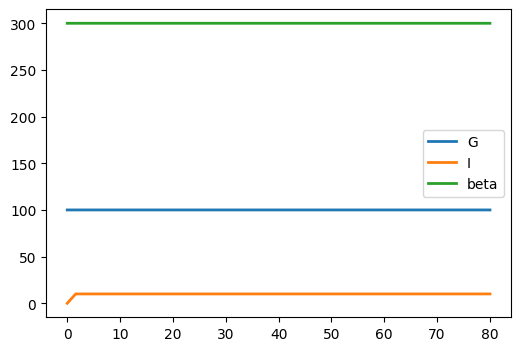

In [4]:
# physiological steady state: beta = 300, G = 100, I = 10
r.plot(result)

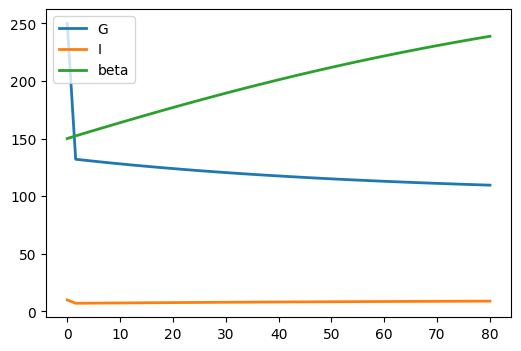

In [5]:
# Try some different values: G = 150?
r.setValue('G', 250)
r.setValue('beta', 150)
result = r.simulate(0, 80)
r.plot(result)

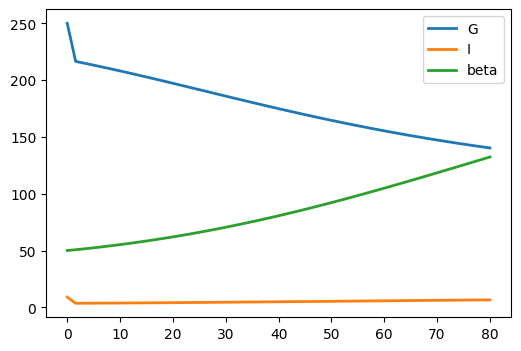

In [6]:
# Try some different values: G = 150?
r.setValue('G', 250)
r.setValue('beta', 50)
result = r.simulate(0, 80)
r.plot(result)

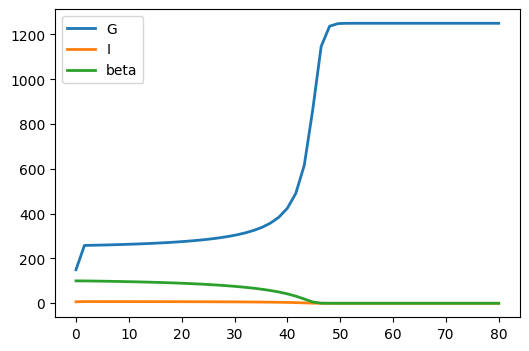

In [7]:
# Converging to pathological state - increasing daily net glucose production
r.setValue('G', 150)
r.setValue('beta', 100)
r.setValue('R0', 1800)
result = r.simulate(0, 80)
r.plot(result)

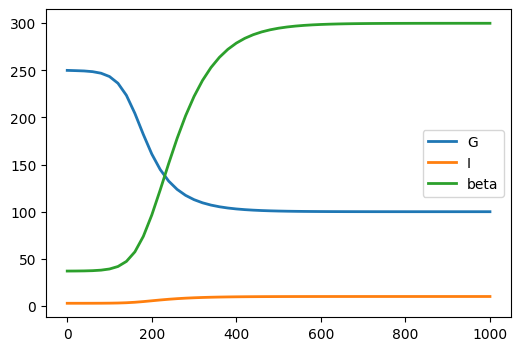

In [8]:
# saddle point
r.resetAll()
r.setValue('G', 250)
r.setValue('beta', 37)
r.setValue('I', 2.8)
result = r.simulate(0, 1000)
r.plot(result)

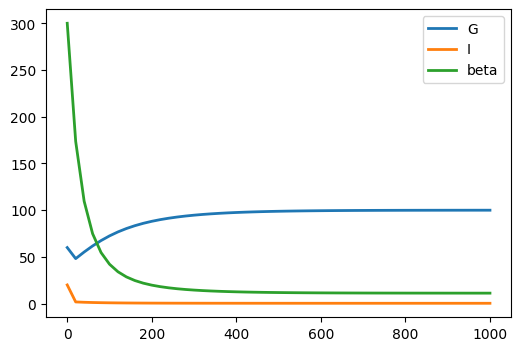

99.97099975948865


In [9]:
# saddle point
r.resetToOrigin()
r.setValue('G', 60)
r.setValue('I', 20)
r.setValue('SI', 1.5)
r.setValue('R0', 200)
result = r.simulate(0, 1000)
r.plot(result)
print(result['G'][-1])

## Parameter sensitivity estimates

Latin hypercube sampling?

In [10]:
print(r.getGlobalParameterValues())
print(r.getGlobalParameterIds())
print(r.getGlobalParameterByName('k'))

[2.00e+02 1.44e+00 1.50e+00 4.32e+01 2.00e+04 4.32e+02 6.00e-02 8.40e-04
 2.40e-06]
['R0', 'EG0', 'SI', 'sigma', 'alpha', 'k', 'd0', 'r1', 'r2']
432.0


In [11]:
r.setValue('R0', 864)

In [12]:
from scipy.stats import qmc
from scipy.stats.qmc import LatinHypercube

In [13]:
parameter_ranges = {#parameters
                    'SI': [0.1, 2],
                    'EG0': [0.1, 5],
                    'R0': [100, 2000],
                    'sigma': [20, 80],
                    'alpha': [10000, 40000],
                    'k': [200, 800],
                    'd0': [0.01, 0.1],
                    'r1': [0.1e-3, 0.1e-2],
                    'r2': [0.1e-6, 0.1e-4],
                    # initial conditions
                    'G': [50, 200],
                    'I': [0, 30],
                    'beta': [100, 500],
                   }
                    

In [14]:
sampler = LatinHypercube(len(parameter_ranges))

In [24]:
n_samples = 1000
samples = sampler.random(n_samples)
all_param_vals = []
for i in range(n_samples):
    sample = samples[i]
    param_vals = {}
    r.resetToOrigin()
    for j, (param_id, param_range) in enumerate(parameter_ranges.items()):
        pv = sample[j]*(param_range[1] - param_range[0]) + param_range[0]
        r.setValue(param_id, pv)
        param_vals[param_id] = pv
    result = r.simulate(0, 1000)
    param_vals['G_final'] = result['G'][-1]
    param_vals['I_final'] = result['I'][-1]
    param_vals['beta_final'] = result['beta'][-1]
    print(param_vals)
    all_param_vals.append(param_vals)

{'SI': 0.39257725938083343, 'EG0': 1.7140886177069192, 'R0': 883.4074791014388, 'sigma': 29.265217879789724, 'alpha': 13124.106597211474, 'k': 245.01078969687057, 'd0': 0.05569165625172601, 'r1': 0.0005016317038915532, 'r2': 9.384574390502826e-06, 'G': 167.89158389225196, 'I': 9.671211677146324, 'beta': 454.63715521012136, 'G_final': 515.3802842954802, 'I_final': 1.8289078762569204e-23, 'beta_final': 1.6301627410081514e-22}
{'SI': 0.8325917748401207, 'EG0': 0.49206565239191447, 'R0': 263.5368782056012, 'sigma': 37.86373362036214, 'alpha': 35342.53744790462, 'k': 561.6751279470658, 'd0': 0.03418828425672413, 'r1': 0.0007789693914824961, 'r2': 2.1725548195326222e-06, 'G': 118.03101604678456, 'I': 2.4563047721464715, 'beta': 287.62031691994383, 'G_final': 51.201925616350756, 'I_final': 5.590910013103925, 'beta_final': 1201.0072599914906}
{'SI': 1.1074705274401753, 'EG0': 2.0469407931343673, 'R0': 1896.5834620723765, 'sigma': 54.24635628512265, 'alpha': 12370.778277432346, 'k': 403.5362400

In [25]:
import pandas as pd

In [26]:
df = pd.DataFrame(all_param_vals)

In [27]:
df

,SI,EG0,R0,sigma,alpha,k,d0,r1,r2,G,I,beta,G_final,I_final,beta_final
0,0.392577,1.714089,883.407479,29.265218,13124.106597,245.010790,0.055692,0.000502,9.384574e-06,167.891584,9.671212,454.637155,515.380284,1.828908e-23,1.630163e-22
1,0.832592,0.492066,263.536878,37.863734,35342.537448,561.675128,0.034188,0.000779,2.172555e-06,118.031016,2.456305,287.620317,51.201926,5.590910e+00,1.201007e+03
2,1.107471,2.046941,1896.583462,54.246356,12370.778277,403.536240,0.066967,0.000552,2.842095e-06,155.992988,22.701060,373.274520,926.545344,1.626361e-23,1.222447e-22
3,1.274312,0.287817,126.098624,52.715887,29452.155240,571.289464,0.095880,0.000993,6.709565e-06,103.853854,8.287264,270.409122,438.120949,2.942179e-21,4.038607e-20
4,0.916712,4.757481,191.464896,38.994772,27198.963807,538.864799,0.018253,0.000578,2.763879e-06,118.670611,26.012270,236.329645,37.467010,3.847633e-01,1.083369e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.124753,1.153110,164.938405,78.823332,14878.288459,281.858497,0.060670,0.000183,4.674290e-06,58.557170,28.056897,489.054451,143.037859,-1.172441e-14,-7.237820e-14
996,0.645936,1.949919,413.424718,60.772362,11180.339964,322.065245,0.076402,0.000906,5.905246e-06,199.625844,23.916611,185.738747,212.021440,-1.419740e-18,-9.390769e-18
997,0.280927,0.377785,1597.805671,59.925507,11871.513223,666.903600,0.083482,0.000986,1.290077e-06,119.031115,3.741612,452.844187,96.975650,5.730527e+01,1.442800e+03
998,0.530737,3.817589,1191.512873,39.881886,26132.915436,240.674498,0.013233,0.000197,4.460428e-06,176.358490,23.198779,384.803383,312.111325,1.574772e-19,1.203335e-18


### SALib

In [157]:
import SALib
import numpy as np

from SALib.sample import fast_sampler, finite_diff, latin, sobol
from SALib.sample import ff as ff_sampler
from SALib.analyze import fast, delta, dgsm, ff

In [158]:
r.resetToOrigin()
bounds = []
params = r.getGlobalParameterIds() + r.getBoundarySpeciesIds()
for x in np.concatenate([r.getGlobalParameterValues(), r.getBoundarySpeciesAmounts()]):
    if x > 0:
        bounds.append([x*0.1, x*10])
    elif x == 0:
        bounds.append([0, 10])
    elif x < 0:
        bounds.append([x*10, x*0.1])
        
problem = {
    'num_vars': len(params),
    'names': params,
    'bounds': bounds,
    'outputs': ['G', 'I', 'beta'],
}

In [159]:
def topp_2000_evaluate(X, t=1000, model=r):
    model.resetToOrigin()
    all_results = []
    for i in range(X.shape[0]):
        x = X[i]
        for index, p in enumerate(params):
            model.setValue(p, x[index])
        results = model.simulate(t)
        #outputs = np.concatenate([x, [results['G'][-1], results['I'][-1], results['beta'][-1]]])
        outputs = [results['G'][-1], results['I'][-1], results['beta'][-1]]
        all_results.append(outputs)
    return np.array(all_results)

### Latin Hypercube Sampling + Delta Moment-Independent Analysis 

see https://salib.readthedocs.io/en/latest/api/SALib.analyze.html#module-SALib.analyze.delta

ref: http://www.relialab.org/Upload/files/A%20new%20uncertainty%20importance%20measure.pdf

This appears to only allow one output variable, so let's just say it's 'G' after equilibrium.

In [176]:
X = latin.sample(problem, 5000)

In [177]:
X.shape

(5000, 12)

In [178]:
Y = topp_2000_evaluate(X)

In [179]:
Y.shape

(5000, 3)

In [180]:
Si = delta.analyze(problem, X, Y[:, 0])

<AxesSubplot:>

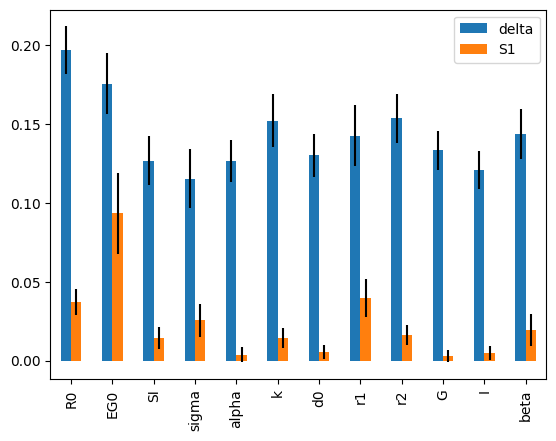

In [181]:
Si.plot()

### DGSM (Derivative-based Global Sensitivity Measure)

See: https://salib.readthedocs.io/en/latest/api/SALib.analyze.html#module-SALib.analyze.dgsm

Ref: https://www.sciencedirect.com/science/article/abs/pii/S0378475409000354, https://arxiv.org/pdf/1412.2619.pdf

In [160]:
X = finite_diff.sample(problem, 3000)

In [161]:
Y = topp_2000_evaluate(X)

In [165]:
Si_dgsm = dgsm.analyze(problem, X, Y[:,0])

In [168]:
Si_dgsm

{'vi': array([1.06587772e-01, 2.40049000e+06, 5.97594071e+06, 5.05518046e+02,
        2.96689820e-04, 3.65421900e-01, 6.00913517e+06, 4.94476309e+11,
        1.90277726e+16, 1.62389069e-02, 3.27304575e-01, 4.14929555e+01]),
 'vi_std': array([1.69810245e+00, 5.08211655e+07, 3.06484543e+08, 2.03267759e+04,
        9.45831342e-03, 7.03879777e+00, 1.44552698e+08, 1.42646651e+13,
        3.72417305e+17, 4.41063195e-01, 8.84066530e+00, 2.08969572e+03]),
 'dgsm': array([6.79370586e-01, 4.25007658e+01, 2.64510638e+01, 8.05519443e+00,
        1.01329175e+00, 5.82282765e-01, 1.84708271e-01, 2.97903724e+00,
        9.35798416e-01, 1.38652806e-03, 2.85136988e-06, 3.18851710e+01]),
 'dgsm_conf': array([5.57636540e-02, 1.54307829e+06, 1.08219603e+07, 7.22543420e+02,
        3.69875527e-04, 2.60367102e-01, 5.10646423e+06, 4.80005206e+11,
        1.35970756e+16, 1.49513363e-02, 3.23143663e-01, 7.79374011e+01]),
 'names': ['R0',
  'EG0',
  'SI',
  'sigma',
  'alpha',
  'k',
  'd0',
  'r1',
  'r2',
  'G

<AxesSubplot:>

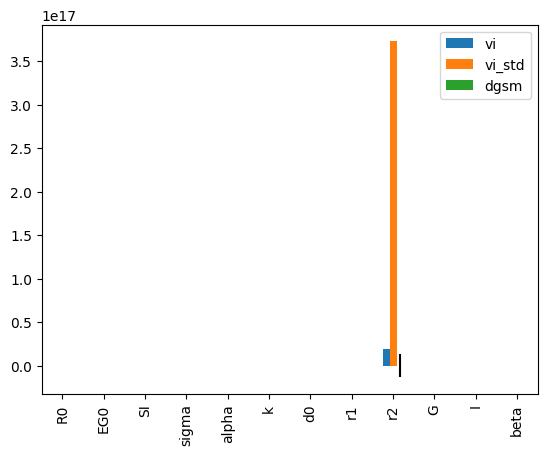

In [170]:
Si_dgsm.plot()

### RBD-Fast

S1 indicates the effect of the variable on the outcome

In [171]:
X = latin.sample(problem, 3000)

In [172]:
Y = topp_2000_evaluate(X)

In [173]:
from SALib.analyze import rbd_fast

In [183]:
Si_rbd_fast = rbd_fast.analyze(problem, X, Y[:, 0])

<AxesSubplot:>

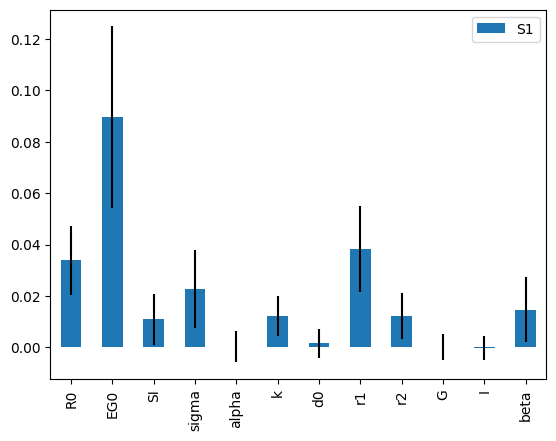

In [184]:
Si_rbd_fast.plot()

In [185]:
Si_rbd_fast

{'S1': [0.033888611052607424,
  0.08956919746090415,
  0.01098032451782307,
  0.02267691951677429,
  0.0002621124259335793,
  0.012296608163796675,
  0.0015210133910279278,
  0.03830536344153221,
  0.01199543970234853,
  4.6498773213923296e-05,
  -0.0001995321329820031,
  0.014607043871327023],
 'S1_conf': [0.013373644157257052,
  0.03529127746064074,
  0.009936614020765303,
  0.015290094468813518,
  0.006165536265057679,
  0.007767605765989292,
  0.0057179270022581245,
  0.01666806833741601,
  0.008953007695246134,
  0.0049757457697135994,
  0.0045956113818012585,
  0.012586501303387943],
 'names': ['R0',
  'EG0',
  'SI',
  'sigma',
  'alpha',
  'k',
  'd0',
  'r1',
  'r2',
  'G',
  'I',
  'beta']}

### PAWN

https://salib.readthedocs.io/en/latest/api/SALib.analyze.html#module-SALib.analyze.pawn

In [186]:
X = latin.sample(problem, 3000)

In [187]:
Y = topp_2000_evaluate(X)

In [188]:
from SALib.analyze import pawn

In [190]:
Si_pawn = pawn.analyze(problem, X, Y[:, 0])

In [192]:
Si_pawn

{'minimum': array([0.068     , 0.04266667, 0.05533333, 0.063     , 0.03933333,
        0.04933333, 0.057     , 0.08366667, 0.041     , 0.025     ,
        0.02066667, 0.032     ]),
 'mean': array([0.17316187, 0.07371706, 0.11568495, 0.11439097, 0.11031862,
        0.12417068, 0.1464641 , 0.19976867, 0.09408606, 0.04454627,
        0.04613913, 0.10776511]),
 'median': array([0.15116667, 0.06733333, 0.10416667, 0.08983333, 0.0895    ,
        0.12      , 0.122     , 0.18683333, 0.09216667, 0.0405    ,
        0.04269565, 0.09283333]),
 'maximum': array([0.54833333, 0.14266667, 0.248     , 0.26033333, 0.27      ,
        0.327     , 0.25830769, 0.339     , 0.17952731, 0.06533333,
        0.083     , 0.26766667]),
 'CV': array([0.76823576, 0.3802999 , 0.48589588, 0.50831152, 0.62203672,
        0.60995571, 0.47684282, 0.44366208, 0.46979336, 0.32644562,
        0.39238485, 0.60213355]),
 'names': ['R0',
  'EG0',
  'SI',
  'sigma',
  'alpha',
  'k',
  'd0',
  'r1',
  'r2',
  'G',
  'I',
  '

<AxesSubplot:>

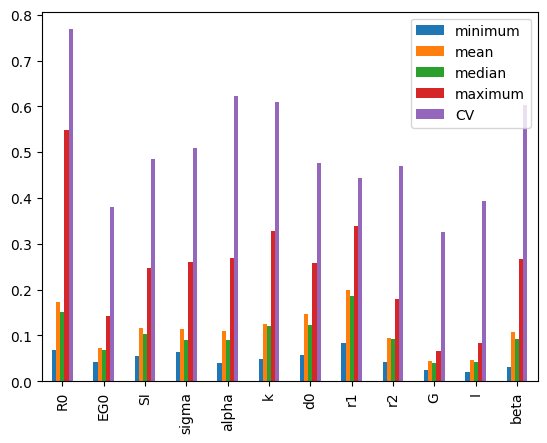

In [193]:
Si_pawn.plot()

### Morris

https://salib.readthedocs.io/en/latest/api/SALib.analyze.html#module-SALib.analyze.morris

mu = mean of distribution, mu* = absolute value of mean, sigma = stdev of distribution

Si – A dictionary of sensitivity indices containing the following entries.

    mu - the mean elementary effect

    mu_star - the absolute of the mean elementary effect

    sigma - the standard deviation of the elementary effect

    mu_star_conf - the bootstrapped confidence interval

In [195]:
from SALib.sample import morris as morris_sampler

In [196]:
X = morris_sampler.sample(problem, 3000)
Y = topp_2000_evaluate(X)

In [198]:
from SALib.analyze import morris

In [199]:
Si_morris = morris.analyze(problem, X, Y[:, 0])

In [200]:
Si_morris

{'names': ['R0',
  'EG0',
  'SI',
  'sigma',
  'alpha',
  'k',
  'd0',
  'r1',
  'r2',
  'G',
  'I',
  'beta'],
 'mu': array([ 3.18212482e+03, -4.33846881e+03, -1.52321563e+03, -1.31375608e+03,
         2.70780334e+02,  1.31729452e+03,  3.00174763e+02, -9.94795012e+02,
         1.57888683e+03,  7.85716369e+01, -1.75258674e+00, -1.43844063e+03]),
 'mu_star': masked_array(data=[3182.90155099712, 4341.984661084651,
                    1523.2156415914997, 1313.757004873117,
                    270.78045446218164, 1317.294536861399,
                    300.1754618388033, 994.7950252542505,
                    1578.886836763078, 79.75848989451276,
                    1.776778133186411, 1438.4406428133964],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value=1e+20),
 'sigma': array([ 8728.04781005, 11252.10066898,  6457.23891333,  5674.05860795,
         1870.23452655,  5789.25809246,  1837.42320307,  

<AxesSubplot:>

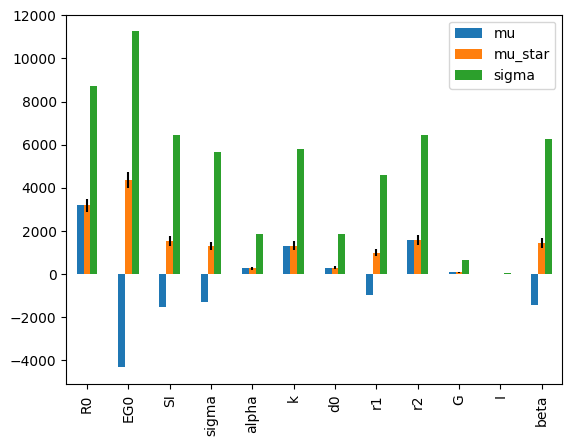

In [201]:
Si_morris.plot()

## Scratch

          ST   ST_conf
x1  0.555860  0.093214
x2  0.441898  0.038098
x3  0.244675  0.024509
          S1   S1_conf
x1  0.316832  0.058342
x2  0.443763  0.052267
x3  0.012203  0.052494
                S2   S2_conf
(x1, x2)  0.009254  0.080414
(x1, x3)  0.238172  0.088224
(x2, x3) -0.004888  0.060000
Samples:
	3 parameters: ['x1', 'x2', 'x3']
	8192 evaluations 

Outputs:
	1 outputs: ['Y']
	8192 evaluations 

Analysis:
          ST   ST_conf
x1  0.555860  0.093214
x2  0.441898  0.038098
x3  0.244675  0.024509 

          S1   S1_conf
x1  0.316832  0.058342
x2  0.443763  0.052267
x3  0.012203  0.052494 

                S2   S2_conf
(x1, x2)  0.009254  0.080414
(x1, x3)  0.238172  0.088224
(x2, x3) -0.004888  0.060000 


[[-3.13238877 -0.77619428 -0.32827189]
 [-0.08283496 -0.77619428 -0.32827189]
 [-3.13238877  0.3589515  -0.32827189]
 ...
 [-0.93572828  0.80073797  0.99095159]
 [-0.93572828  0.81914574  2.70901007]
 [-0.93572828  0.81914574  0.99095159]]
[ 3.426362    3.3527401   0.85463

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

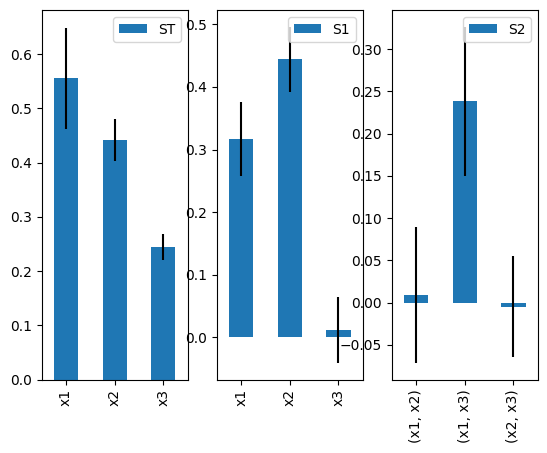

In [74]:
from SALib import ProblemSpec
from SALib.test_functions import Ishigami

import numpy as np


# By convention, we assign to "sp" (for "SALib Problem")
sp = ProblemSpec({
  'names': ['x1', 'x2', 'x3'],   # Name of each parameter
  'bounds': [[-np.pi, np.pi]]*3,  # bounds of each parameter
  'outputs': ['Y']               # name of outputs in expected order
})

(sp.sample_saltelli(1024, calc_second_order=True)
   .evaluate(Ishigami.evaluate)
   .analyze_sobol(print_to_console=True))

print(sp)

# Samples, model results and analyses can be extracted:
print(sp.samples)
print(sp.results)
print(sp.analysis)

# Basic plotting functionality is also provided
sp.plot()

In [75]:
Ishigami.evaluate?

Signature: Ishigami.evaluate(X: numpy.ndarray, A: float = 7.0, B: float = 0.1) -> numpy.ndarray
Docstring:
Non-monotonic Ishigami-Homma three parameter test function:

`f(x) = \sin(x_{1}) + A \sin(x_{2})^2 + Bx^{4}_{3}\sin(x_{1})`

This test function is commonly used to benchmark global sensitivity
methods as variance-based sensitivities of this function can be
analytically determined.

See listed references below.

In [2], the expected first-order indices are:

    x1: 0.3139
    x2: 0.4424
    x3: 0.0

when A = 7, B = 0.1 when conducting Sobol' analysis with the
Saltelli sampling method with a sample size of 1000.


Parameters
----------
X : np.ndarray
    An `N*D` array holding values for each parameter, where `N` is the
    number of samples and `D` is the number of parameters
    (in this case, three).
A : float
    Constant `A` parameter
B : float
    Constant `B` parameter

Returns
-------
Y : np.ndarray

References
----------
.. [1] Ishigami, T., Homma, T., 1990.
       An impo

In [84]:
from SALib.sample import saltelli
from SALib.analyze import sobol, delta, dgsm
from SALib.test_functions import Ishigami
import numpy as np

In [106]:
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

In [107]:
param_values = saltelli.sample(problem, 1024)

/tmp/ipykernel_3411/1862108280.py:1: DeprecationWarning:

`salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`



In [108]:
Y = Ishigami.evaluate(param_values)

In [109]:
Y.shape

(8192,)

In [114]:
param_values.shape

(8192, 3)

In [115]:
saltelli.sample?

Signature:
saltelli.sample(
    problem: Dict,
    N: int,
    calc_second_order: bool = True,
    skip_values: int = None,
)
Docstring:
Generates model inputs using Saltelli's extension of the Sobol' sequence

The Sobol' sequence is a popular quasi-random low-discrepancy sequence used
to generate uniform samples of parameter space.

Returns a NumPy matrix containing the model inputs using Saltelli's
sampling scheme.
Saltelli's scheme extends the Sobol' sequence in a way to reduce
the error rates in the resulting sensitivity index calculations. If
`calc_second_order` is False, the resulting matrix has ``N * (D + 2)``
rows, where ``D`` is the number of parameters.
If `calc_second_order` is `True`, the resulting matrix has ``N * (2D + 2)``
rows.
These model inputs are intended to be used with
:func:`SALib.analyze.sobol.analyze`.

.. deprecated:: 1.4.6

Notes
-----
The initial points of the Sobol' sequence has some repetition (see Table 2
in Campolongo [1]), which can be avoided by settin